# Build a Question Answering application over a Graph Database

In this guide we'll go over the basic ways to create a Q&A chain over a graph database. These systems will allow us to ask a question about the data in a graph database and get back a natural language answer. First, we will show a simple out-of-the-box option and then implement a more sophisticated version with LangGraph.

## ⚠️ Security note ⚠️

Building Q&A systems of graph databases requires executing model-generated graph queries. There are inherent risks in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible for your chain/agent's needs. This will mitigate though not eliminate the risks of building a model-driven system. For more on general security best practices, [see here](/docs/security).


## Architecture

At a high-level, the steps of most graph chains are:

1. **Convert question to a graph database query**: Model converts user input to a graph database query (e.g. Cypher).
2. **Execute graph database query**: Execute the graph database query.
3. **Answer the question**: Model responds to user input using the query results.


![sql_usecase.png](../../static/img/graph_usecase.png)

## Setup

First, get required packages and set environment variables.
In this example, we will be using Neo4j graph database.

In [ ]:
%pip install --upgrade --quiet langchain langchain-neo4j langchain-openai langgraph

We default to OpenAI models in this guide.

In [2]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

# Uncomment the below to use LangSmith. Not required.
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()
# os.environ["LANGCHAIN_TRACING_V2"] = "true"

Enter your OpenAI API key:  ········


Next, we need to define Neo4j credentials.
Follow [these installation steps](https://neo4j.com/docs/operations-manual/current/installation/) to set up a Neo4j database.

In [3]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"

The below example will create a connection with a Neo4j database and will populate it with example data about movies and their actors.

In [4]:
from langchain_neo4j import Neo4jGraph

graph = Neo4jGraph()

# Import movie information

movies_query = """
LOAD CSV WITH HEADERS FROM 
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') | 
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') | 
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') | 
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

graph.query(movies_query)

[]

## Graph schema

In order for an LLM to be able to generate a Cypher statement, it needs information about the graph schema. When you instantiate a graph object, it retrieves the information about the graph schema. If you later make any changes to the graph, you can run the `refresh_schema` method to refresh the schema information.

In [5]:
graph.refresh_schema()
print(graph.schema)

Node properties:
Person {name: STRING}
Movie {id: STRING, released: DATE, title: STRING, imdbRating: FLOAT}
Genre {name: STRING}
Chunk {id: STRING, embedding: LIST, text: STRING, question: STRING, query: STRING}
Relationship properties:

The relationships:
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)
(:Movie)-[:IN_GENRE]->(:Genre)


For more involved schema information, you can use `enhanced_schema` option.

In [6]:
enhanced_graph = Neo4jGraph(enhanced_schema=True)
print(enhanced_graph.schema)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


Node properties:
- **Person**
  - `name`: STRING Example: "John Lasseter"
- **Movie**
  - `id`: STRING Example: "1"
  - `released`: DATE Min: 1964-12-16, Max: 1996-09-15
  - `title`: STRING Example: "Toy Story"
  - `imdbRating`: FLOAT Min: 2.4, Max: 9.3
- **Genre**
  - `name`: STRING Example: "Adventure"
- **Chunk**
  - `id`: STRING Available options: ['d66006059fd78d63f3df90cc1059639a', '0e3dcb4502853979d12357690a95ec17', 'c438c6bcdcf8e4fab227f29f8e7ff204', '97fe701ec38057594464beaa2df0710e', 'b54f9286e684373498c4504b4edd9910', '5b50a72c3a4954b0ff7a0421be4f99b9', 'fb28d41771e717255f0d8f6c799ede32', '58e6f14dd2e6c6702cf333f2335c499c']
  - `text`: STRING Available options: ['How many artists are there?', 'Which actors played in the movie Casino?', 'How many movies has Tom Hanks acted in?', "List all the genres of the movie Schindler's List", 'Which actors have worked in movies from both the c', 'Which directors have made movies with at least thr', 'Identify movies where directors also p

The `enhanced_schema` option enriches property information by including details such as minimum and maximum values for floats and dates, as well as example values for string properties. This additional context helps guide the LLM toward generating more accurate and effective queries.

Great! We've got a graph database that we can query. Now let's try hooking it up to an LLM.

## GraphQACypherChain

Let's use a simple out-of-the-box chain that takes a question, turns it into a Cypher query, executes the query, and uses the result to answer the original question.

![graph_chain.webp](../../static/img/graph_chain.webp)


LangChain comes with a built-in chain for this workflow that is designed to work with Neo4j: [GraphCypherQAChain](/docs/integrations/graphs/neo4j_cypher)

In [7]:
from langchain_neo4j import GraphCypherQAChain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
chain = GraphCypherQAChain.from_llm(
    graph=enhanced_graph, llm=llm, verbose=True, allow_dangerous_requests=True
)
response = chain.invoke({"query": "What was the cast of the Casino?"})
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Person)-[:ACTED_IN]->(m:Movie {title: "Casino"})
RETURN p.name

Full Context:
[{'p.name': 'Robert De Niro'}, {'p.name': 'Joe Pesci'}, {'p.name': 'Sharon Stone'}, {'p.name': 'James Woods'}]

> Finished chain.


{'query': 'What was the cast of the Casino?',
 'result': 'Robert De Niro, Joe Pesci, Sharon Stone, and James Woods were the cast of Casino.'}

## Advanced implementation with LangGraph

While the GraphCypherQAChain is effective for quick demonstrations, it may face challenges in production environments. Transitioning to LangGraph can enhance the workflow, but implementing natural language to query flows in production remains a complex task. Nevertheless, there are several strategies to significantly improve accuracy and reliability, which we will explore next.

Here is the visualized LangGraph flow we will implement:

![langgraph_text2cypher](../../static/img/langgraph_text2cypher.webp)


We will begin by defining the Input, Output, and Overall state of the LangGraph application.

In [8]:
from operator import add
from typing import Annotated, List

from typing_extensions import TypedDict


class InputState(TypedDict):
    question: str


class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]


class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

The first step is a simple `guardrails` step, where we validate whether the question pertains to movies or their cast. If it doesn't, we notify the user that we cannot answer any other questions. Otherwise, we move on to the Cypher generation step.

In [9]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

guardrails_system = """
As an intelligent assistant, your primary objective is to decide whether a given question is related to movies or not. 
If the question is related to movies, output "movie". Otherwise, output "end".
To make this decision, assess the content of the question and determine if it refers to any movie, actor, director, film industry, 
or related topics. Provide only the specified output: "movie" or "end".
"""
guardrails_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            guardrails_system,
        ),
        (
            "human",
            ("{question}"),
        ),
    ]
)


class GuardrailsOutput(BaseModel):
    decision: Literal["movie", "end"] = Field(
        description="Decision on whether the question is related to movies"
    )


guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)


def guardrails(state: InputState) -> OverallState:
    """
    Decides if the question is related to movies or not.
    """
    guardrails_output = guardrails_chain.invoke({"question": state.get("question")})
    database_records = None
    if guardrails_output.decision == "end":
        database_records = "This questions is not about movies or their cast. Therefore I cannot answer this question."
    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records,
        "steps": ["guardrail"],
    }

### Few-shot prompting

Converting natural language into accurate queries is challenging. One way to enhance this process is by providing relevant few-shot examples to guide the LLM in query generation. To achieve this, we will use the `SemanticSimilarityExampleSelector` to dynamically select the most relevant examples.

In [10]:
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_neo4j import Neo4jVector
from langchain_openai import OpenAIEmbeddings

examples = [
    {
        "question": "How many artists are there?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie) RETURN count(DISTINCT a)",
    },
    {
        "question": "Which actors played in the movie Casino?",
        "query": "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a) RETURN a.name",
    },
    {
        "question": "How many movies has Tom Hanks acted in?",
        "query": "MATCH (a:Person {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN count(m)",
    },
    {
        "question": "List all the genres of the movie Schindler's List",
        "query": "MATCH (m:Movie {title: 'Schindler's List'})-[:IN_GENRE]->(g:Genre) RETURN g.name",
    },
    {
        "question": "Which actors have worked in movies from both the comedy and action genres?",
        "query": "MATCH (a:Person)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g1:Genre), (a)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g2:Genre) WHERE g1.name = 'Comedy' AND g2.name = 'Action' RETURN DISTINCT a.name",
    },
    {
        "question": "Which directors have made movies with at least three different actors named 'John'?",
        "query": "MATCH (d:Person)-[:DIRECTED]->(m:Movie)<-[:ACTED_IN]-(a:Person) WHERE a.name STARTS WITH 'John' WITH d, COUNT(DISTINCT a) AS JohnsCount WHERE JohnsCount >= 3 RETURN d.name",
    },
    {
        "question": "Identify movies where directors also played a role in the film.",
        "query": "MATCH (p:Person)-[:DIRECTED]->(m:Movie), (p)-[:ACTED_IN]->(m) RETURN m.title, p.name",
    },
    {
        "question": "Find the actor with the highest number of movies in the database.",
        "query": "MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) RETURN a.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    },
]

example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, OpenAIEmbeddings(), Neo4jVector, k=5, input_keys=["question"]
)

Next, we implement the Cypher generation chain, also known as **text2cypher**. The prompt includes an enhanced graph schema, dynamically selected few-shot examples, and the user’s question. This combination enables the generation of a Cypher query to retrieve relevant information from the database.

In [11]:
from langchain_core.output_parsers import StrOutputParser

text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
Here is the schema information
{schema}

Below are a number of examples of questions and their corresponding Cypher queries.

{fewshot_examples}

User input: {question}
Cypher query:"""
            ),
        ),
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()


def generate_cypher(state: OverallState) -> OverallState:
    """
    Generates a cypher statement based on the provided schema and user input
    """
    NL = "\n"
    fewshot_examples = (NL * 2).join(
        [
            f"Question: {el['question']}{NL}Cypher:{el['query']}"
            for el in example_selector.select_examples(
                {"question": state.get("question")}
            )
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "fewshot_examples": fewshot_examples,
            "schema": enhanced_graph.schema,
        }
    )
    return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

### Query validation

The next step is to validate the generated Cypher statement and ensuring that all property values are accurate. While numbers and dates typically don’t require validation, strings such as movie titles or people’s names do. In this example, we’ll use a basic `CONTAINS` clause for validation, though more advanced mapping and validation techniques can be implemented if needed.

First, we will create a chain that detects any errors in the Cypher statement and extracts the property values it references.

In [12]:
from typing import List, Optional

validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefined variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the properties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Examples of good errors:
* Label (:Foo) does not exist, did you mean (:Bar)?
* Property bar does not exist for label Foo, did you mean baz?
* Relationship FOO does not exist, did you mean FOO_BAR?

Schema:
{schema}

The question is:
{question}

The Cypher statement is:
{cypher}

Make sure you don't make any mistakes!"""

validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


class Property(BaseModel):
    """
    Represents a filter condition based on a specific node property in a graph in a Cypher statement.
    """

    node_label: str = Field(
        description="The label of the node to which this property belongs."
    )
    property_key: str = Field(description="The key of the property being filtered.")
    property_value: str = Field(
        description="The value that the property is being matched against."
    )


class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output,
    including any errors and applied filters.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )
    filters: Optional[List[Property]] = Field(
        description="A list of property-based filters applied in the Cypher statement."
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

LLMs often struggle with correctly determining relationship directions in generated Cypher statements. Since we have access to the schema, we can deterministically correct these directions using the **CypherQueryCorrector**. 

*Note: The `CypherQueryCorrector` is an experimental feature and doesn't support all the newest Cypher syntax.*

In [13]:
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

# Cypher query corrector is experimental
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in enhanced_graph.structured_schema.get("relationships")
]
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

Now we can implement the Cypher validation step. First, we use the `EXPLAIN` method to detect any syntax errors. Next, we leverage the LLM to identify potential issues and extract the properties used for filtering. For string properties, we validate them against the database using a simple `CONTAINS` clause.

Based on the validation results, the process can take the following paths:

- If value mapping fails, we end the conversation and inform the user that we couldn't identify a specific property value (e.g., a person or movie title).  
- If errors are found, we route the query for correction.  
- If no issues are detected, we proceed to the Cypher execution step.  

In [14]:
from neo4j.exceptions import CypherSyntaxError


def validate_cypher(state: OverallState) -> OverallState:
    """
    Validates the Cypher statements and maps any property values to the database.
    """
    errors = []
    mapping_errors = []
    # Check for syntax errors
    try:
        enhanced_graph.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    # Experimental feature for correcting relationship directions
    corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    if not corrected_cypher:
        errors.append("The generated Cypher statement doesn't fit the graph schema")
    if not corrected_cypher == state.get("cypher_statement"):
        print("Relationship direction was corrected")
    # Use LLM to find additional potential errors and get the mapping for values
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": enhanced_graph.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)
    if llm_output.filters:
        for filter in llm_output.filters:
            # Do mapping only for string values
            if (
                not [
                    prop
                    for prop in enhanced_graph.structured_schema["node_props"][
                        filter.node_label
                    ]
                    if prop["property"] == filter.property_key
                ][0]["type"]
                == "STRING"
            ):
                continue
            mapping = enhanced_graph.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n.`{filter.property_key}`) = toLower($value) RETURN 'yes' LIMIT 1",
                {"value": filter.property_value},
            )
            if not mapping:
                print(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
                mapping_errors.append(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

The Cypher correction step takes the existing Cypher statement, any identified errors, and the original question to generate a corrected version of the query.

In [15]:
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """
            ),
        ),
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()


def correct_cypher(state: OverallState) -> OverallState:
    """
    Correct the Cypher statement based on the provided errors.
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": enhanced_graph.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"],
    }

We need to add a step that executes the given Cypher statement. If no results are returned, we should explicitly handle this scenario, as leaving the context empty can sometimes lead to LLM hallucinations.

In [16]:
no_results = "I couldn't find any relevant information in the database"


def execute_cypher(state: OverallState) -> OverallState:
    """
    Executes the given Cypher statement.
    """

    records = enhanced_graph.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

The final step is to generate the answer. This involves combining the initial question with the database output to produce a relevant response.

In [17]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
a succinct, definitive answer to the user's question.

Respond as if you are answering the question directly.

Results: {results}
Question: {question}"""
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: OverallState) -> OutputState:
    """
    Decides if the question is related to movies.
    """
    final_answer = generate_final_chain.invoke(
        {"question": state.get("question"), "results": state.get("database_records")}
    )
    return {"answer": final_answer, "steps": ["generate_final_answer"]}

Next, we will implement the LangGraph workflow, starting with defining the conditional edge functions.

In [18]:
def guardrails_condition(
    state: OverallState,
) -> Literal["generate_cypher", "generate_final_answer"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "movie":
        return "generate_cypher"


def validate_cypher_condition(
    state: OverallState,
) -> Literal["generate_final_answer", "correct_cypher", "execute_cypher"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"

Let's put it all together now.

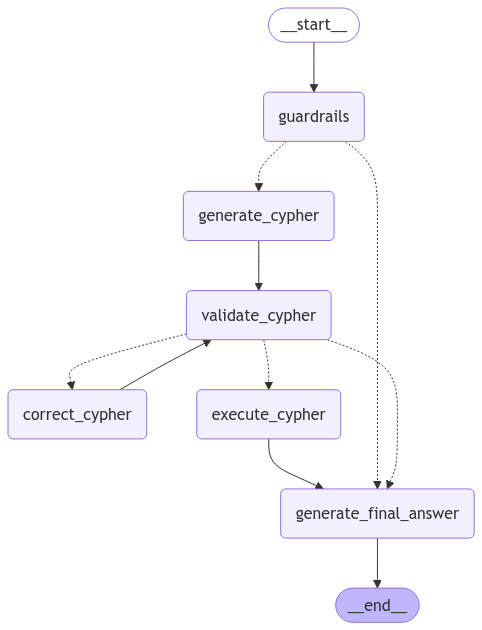

In [19]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
langgraph.add_node(guardrails)
langgraph.add_node(generate_cypher)
langgraph.add_node(validate_cypher)
langgraph.add_node(correct_cypher)
langgraph.add_node(execute_cypher)
langgraph.add_node(generate_final_answer)

langgraph.add_edge(START, "guardrails")
langgraph.add_conditional_edges(
    "guardrails",
    guardrails_condition,
)
langgraph.add_edge("generate_cypher", "validate_cypher")
langgraph.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)
langgraph.add_edge("execute_cypher", "generate_final_answer")
langgraph.add_edge("correct_cypher", "validate_cypher")
langgraph.add_edge("generate_final_answer", END)

langgraph = langgraph.compile()

# View
display(Image(langgraph.get_graph().draw_mermaid_png()))

We can now test the application by asking an irrelevant question.

In [20]:
langgraph.invoke({"question": "What's the weather in Spain?"})

{'answer': "I'm sorry, but I cannot provide current weather information. Please check a reliable weather website or app for the latest updates on the weather in Spain.",
 'steps': ['guardrail', 'generate_final_answer']}

Let's now ask something relevant about the movies.

In [21]:
langgraph.invoke({"question": "What was the cast of the Casino?"})

{'answer': 'The cast of "Casino" includes Robert De Niro, Joe Pesci, Sharon Stone, and James Woods.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a:Person) RETURN a.name"}

### Next steps

For other graph techniques like this and more check out:

* [Semantic layer](/docs/how_to/graph_semantic): Techniques for implementing semantic layers.
* [Constructing graphs](/docs/how_to/graph_constructing): Techniques for constructing knowledge graphs.